<a href="https://colab.research.google.com/github/LucasJFaust/bibliotecas_py/blob/main/Case_RFM_Lucas_Faust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto do Projeto

Uma empresa do ramo de e-commerce contratou você para levantar os indicadores de recência, frequência e ticket médio (RFM) dos seus clientes.




# Etapa 01: Leitura do Datasete e inspecione os dados

Esta é a fase inicial de qualquer projeto de análise de dados. Aqui, carregamos o conjunto de dados para ter uma visão geral do que estamos lidando. Observar as primeiras linhas ajuda a entender a estrutura dos dados. A descrição estatística e a verificação dos tipos de dados são essenciais para identificar problemas como valores ausentes, possíveis outliers e a necessidade de converter tipos de dados para formatos mais apropriados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = '/content/data.csv'  # Substitua pelo caminho correto do seu arquivo
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [ ]:
# Visualizando as primeiras linhas para ter uma ideia inicial dos dados
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Descrição estatística para entender melhor a distribuição dos dados
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Verificar os tipos de dados para identificar necessidades de conversão
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Etapa 02: Valores Faltantes na Identificação do Cliente

Dados nulos podem distorcer análises e modelos estatísticos. Especialmente em análises RFM, a identificação do cliente é crucial. Sem ela, não podemos rastrear as compras de volta aos clientes. Remover esses valores assegura a integridade das análises subsequentes.

In [ ]:
# Removendo linhas onde o CustomerID é nulo, pois são essenciais para a análise
data.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
# Verificando as mudanças
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# Etapa 03: Preços Unitários e Quantidade de Produtos

Dados com preços unitários ou quantidades negativas ou iguais a zero são inválidos no contexto de vendas e compras. Removê-los evita distorções nas análises de vendas e no cálculo de métricas importantes como o TotalPrice.

OBS: Compare o impacto desses tratamentos com os describe anterior.

In [ ]:
# Removendo entradas com valores inválidos (preço ou quantidade <= 0)
data = data[(data['UnitPrice'] > 0) & (data['Quantity'] > 0)]

In [ ]:
# Revisão dos dados após a limpeza
data.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


# Etapa 04: Tratamento das Linhas Duplicadas

Duplicatas podem levar a resultados enganosos, como inflacionar a frequência de compras ou o volume de vendas. Sua remoção é crucial para manter a precisão dos dados.

In [ ]:
# Identificando e removendo duplicatas
data.drop_duplicates(inplace=True)

In [ ]:
# Verificando o número de linhas restantes
print(data.shape)

(392692, 8)


#Etapa 05: Tipos de Dados da Coluna

A conversão de tipos de dados é vital para a análise. Por exemplo, o 'CustomerID' deve ser um inteiro para identificação única, e 'InvoiceDate' deve ser um datetime para permitir cálculos relacionados a datas.

**OBS**: Para converter a coluna InvoiceDate, diferente do astype que funciona bem para tipos de dados mais simples como int, float, str e outros tipos nativos do Python ou do NumPy, optei por usar a função to_datetime() que é especialmente projetada para lidar com a conversão de strings e outros tipos de dados em objetos datetime do pandas.

In [ ]:
# Convertendo CustomerID para int e InvoiceDate para datetime
data['CustomerID'] = data['CustomerID'].astype(int)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
# Confirmando as mudanças
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


# Etapa 06: Tratando os Outliers

Outliers podem distorcer análises estatísticas e modelos preditivos. Ao remover valores extremos, garantimos que o foco esteja em dados representativos, melhorando a confiabilidade das análises.

In [ ]:
# Configuração do estilo do gráfico
sns.set(style="whitegrid")

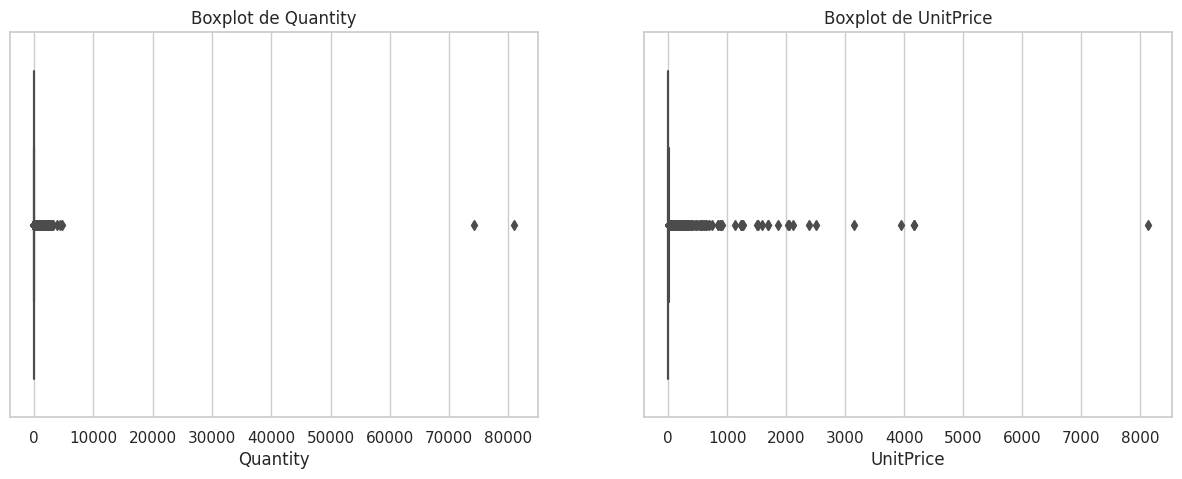

In [ ]:
# Criando subplots para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot para a coluna Quantity
sns.boxplot(x=data['Quantity'], ax=axes[0])
axes[0].set_title('Boxplot de Quantity')

# Boxplot para a coluna UnitPrice
sns.boxplot(x=data['UnitPrice'], ax=axes[1])
axes[1].set_title('Boxplot de UnitPrice')

# Mostrar os gráficos
plt.show()

In [ ]:
# Removendo outliers extremos
data = data[(data['Quantity'] <= 10000) & (data['UnitPrice'] <= 5000)]

In [ ]:
# Analisando os dados após a remoção dos outliers
data.describe()

,Quantity,UnitPrice,CustomerID
count,392689.000000,392689.000000,392689.000000
mean,12.724550,3.105194,15287.846520
std,43.083696,18.055047,1713.538259
min,1.000000,0.001000,12347.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,4800.000000,4161.060000,18287.000000


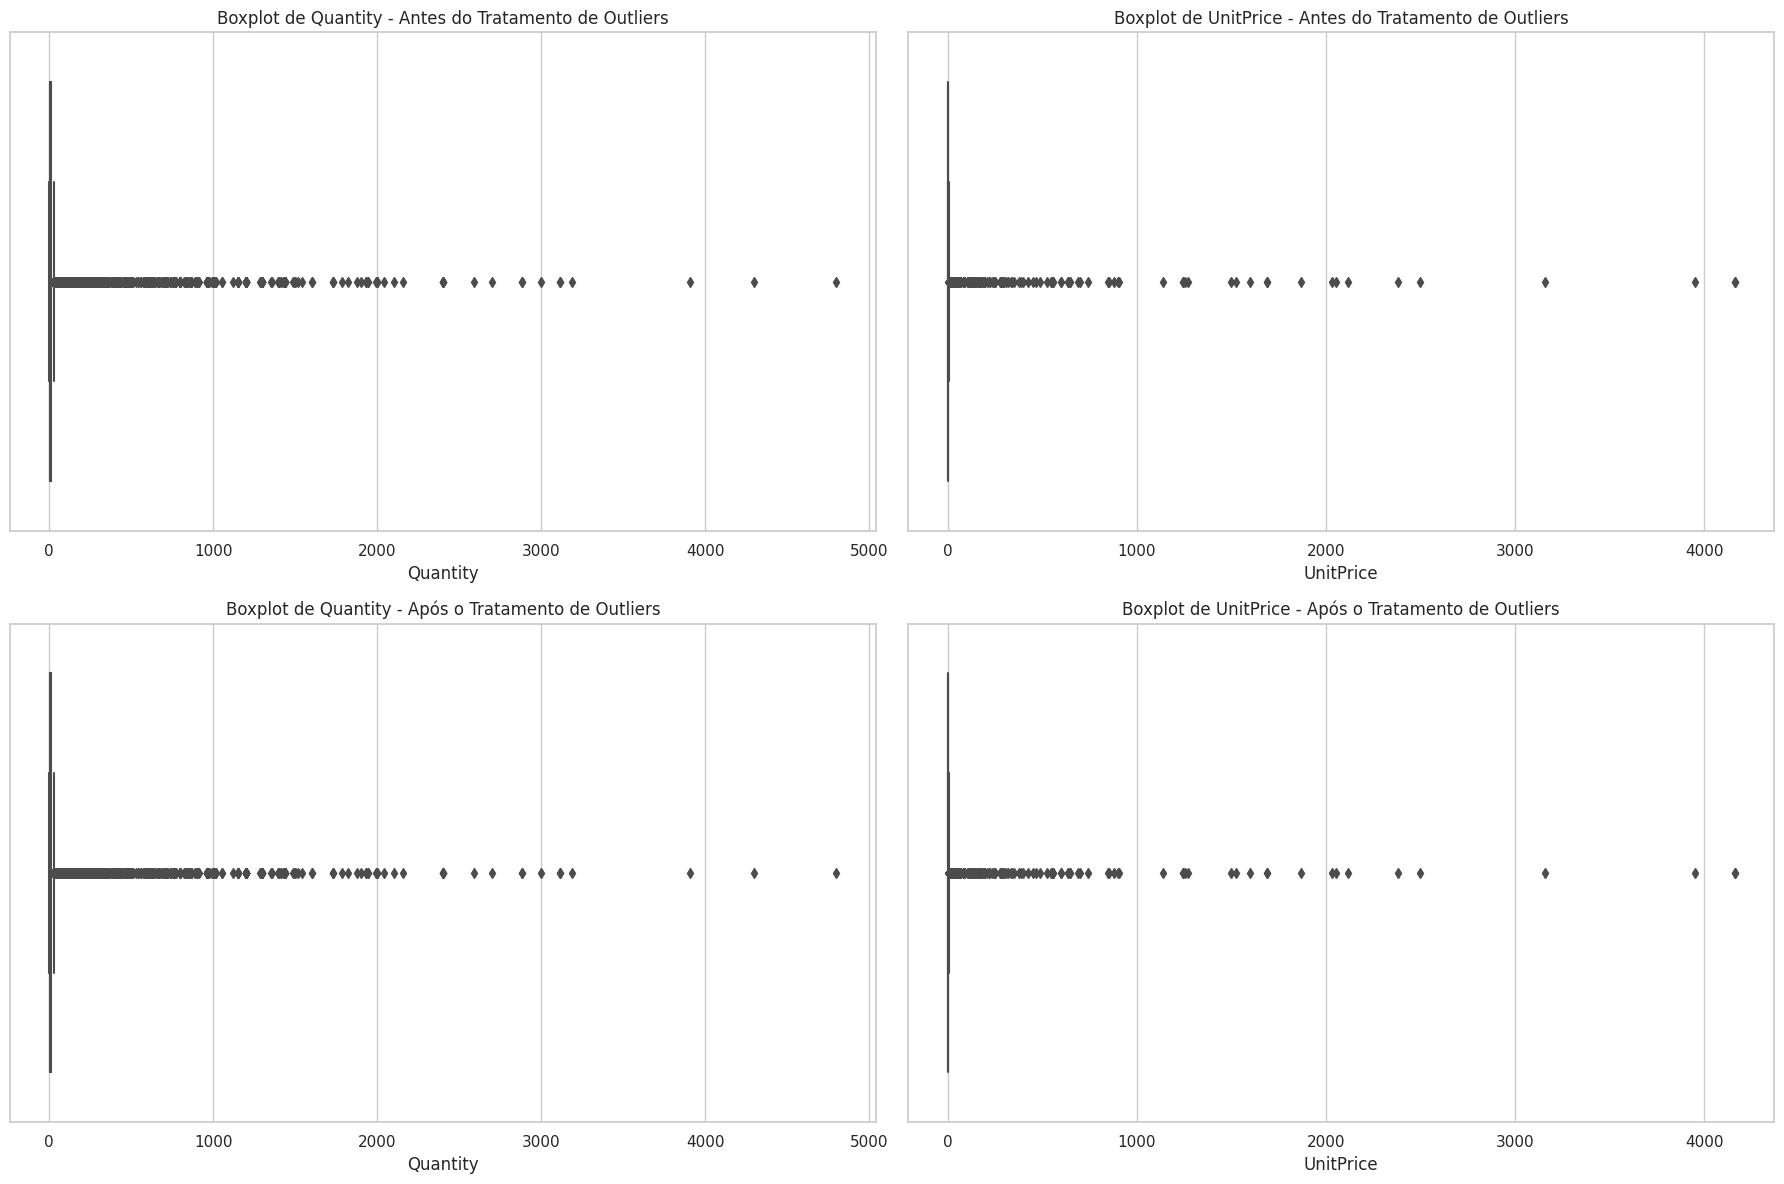

In [ ]:
# Configuração do estilo do gráfico
sns.set(style="whitegrid")

# Criando subplots para os gráficos antes e depois do tratamento de outliers
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Boxplot para a coluna Quantity antes do tratamento de outliers
sns.boxplot(x=data['Quantity'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot de Quantity - Antes do Tratamento de Outliers')

# Boxplot para a coluna UnitPrice antes do tratamento de outliers
sns.boxplot(x=data['UnitPrice'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot de UnitPrice - Antes do Tratamento de Outliers')

# Tratamento de outliers
data_filtered = data[(data['Quantity'] > 0) & (data['Quantity'] <= 10000) &
                     (data['UnitPrice'] > 0) & (data['UnitPrice'] <= 5000)]

# Boxplot para a coluna Quantity após o tratamento de outliers
sns.boxplot(x=data_filtered['Quantity'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot de Quantity - Após o Tratamento de Outliers')

# Boxplot para a coluna UnitPrice após o tratamento de outliers
sns.boxplot(x=data_filtered['UnitPrice'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot de UnitPrice - Após o Tratamento de Outliers')

# Ajustar o layout para evitar sobreposição de títulos e eixos
plt.tight_layout()

# Mostrar os gráficos
plt.show()

# Etapa 07: Coluna Adicional

Aqui vamos Adicionar uma coluna para o preço total (quantidade x preço unitário). Ela é fundamental para análises financeiras. Isso permite avaliar o valor total das transações, que é uma parte importante da análise RFM.

In [ ]:
# Criando uma coluna para o preço total de cada item
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [ ]:
# Verificando as primeiras linhas com a nova coluna
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# Etapa 08: Última Data

Determinar a última data de compra no conjunto de dados é crucial para calcular a métrica de recência no RFM. A recência mede o tempo desde a última compra, sendo um indicador chave do engajamento do cliente.

In [ ]:
# Determinando a data mais recente no dataset
last_date = data['InvoiceDate'].max()
print("Última data de compra no dataset:", last_date)

Última data de compra no dataset: 2011-12-09 12:50:00


# Etapa 09: Análise Gráfica

Gráficos são ferramentas poderosas para visualizar e comunicar padrões e insights nos dados. Eles ajudam a identificar tendências, outliers e segmentos de mercado importantes, facilitando a interpretação dos dados e a tomada de decisões baseada em evidências.

1. Top 10 Países com Maior Valor em Vendas

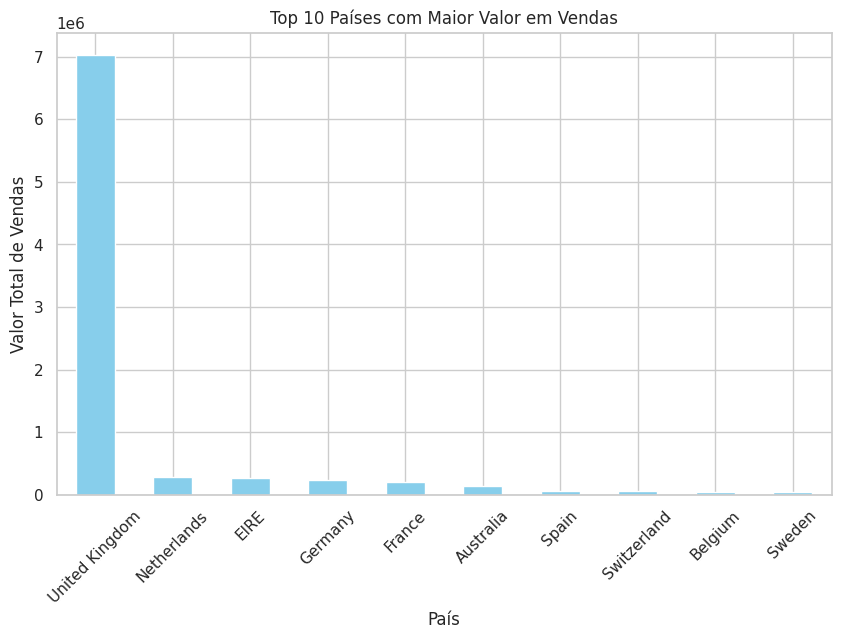

In [ ]:
# Configuração de estilo
sns.set(style="whitegrid")

# Agrupando dados por país e somando o TotalPrice
top_countries = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Criando o gráfico de barras
plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', color='skyblue')
plt.title('Top 10 Países com Maior Valor em Vendas')
plt.xlabel('País')
plt.ylabel('Valor Total de Vendas')
plt.xticks(rotation=45)
plt.show()

2. Top 10 Produtos Mais Vendidos

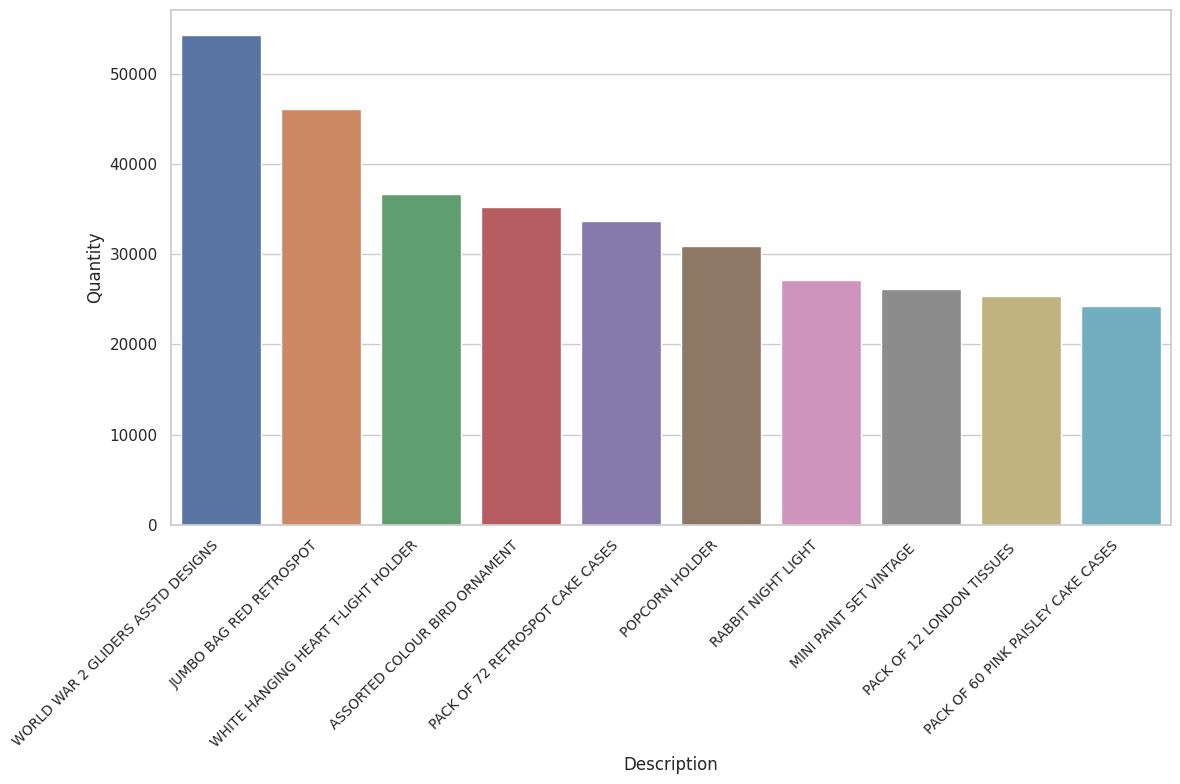

In [ ]:
# Resetando o índice para transformar a Series em DataFrame
top_products = top_products.reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Description', y='Quantity', data=top_products)

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right', fontsize=10)  # 'ha' é a abreviação de 'horizontalalignment'

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

3. Valor de Venda Total por Mês

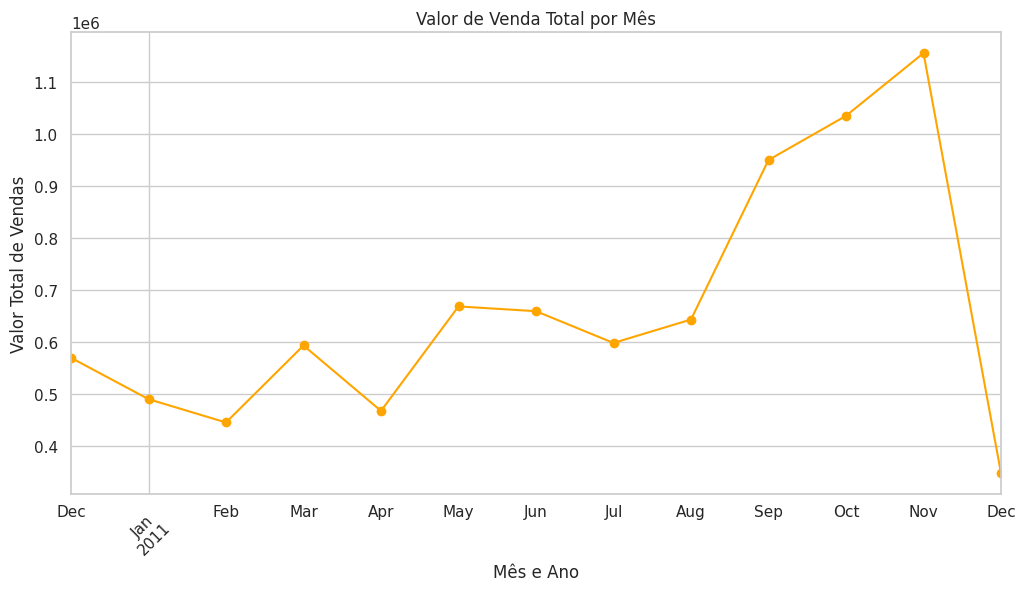

In [ ]:
# Extraindo o mês e o ano da data da fatura
data['Month_Year'] = data['InvoiceDate'].dt.to_period('M')

# Agrupando por mês e ano, e somando o TotalPrice
sales_per_month = data.groupby('Month_Year')['TotalPrice'].sum()

# Criando o gráfico de linha
plt.figure(figsize=(12,6))
sales_per_month.plot(kind='line', marker='o', color='orange')
plt.title('Valor de Venda Total por Mês')
plt.xlabel('Mês e Ano')
plt.ylabel('Valor Total de Vendas')
plt.xticks(rotation=45)
plt.show()

4. Valor de Venda Total por Mês e por País (Considerando apenas os Top 10)

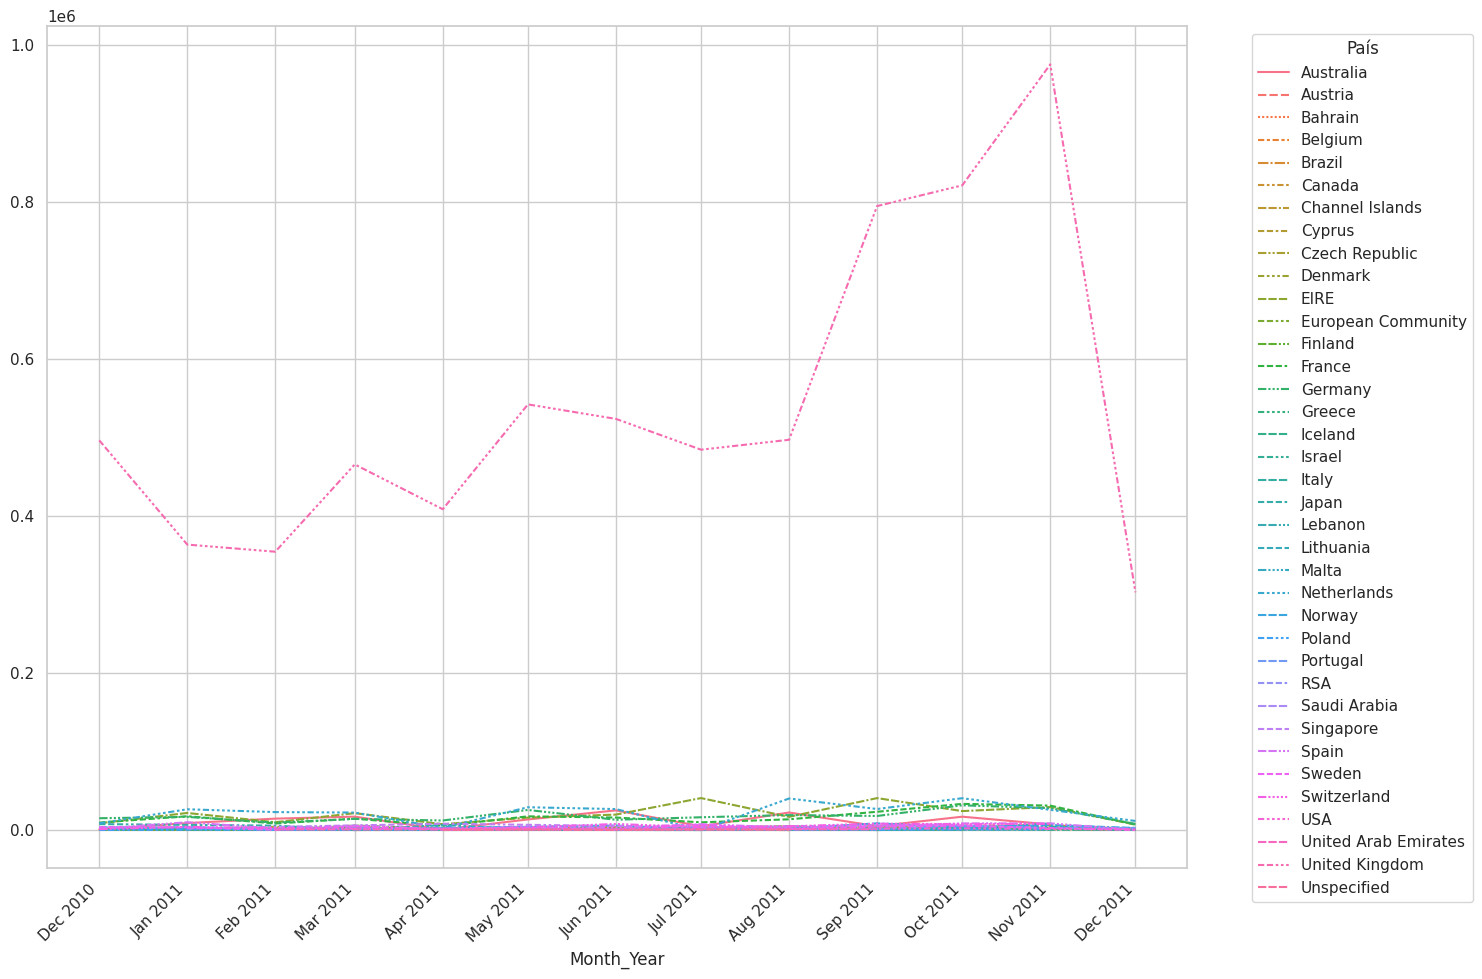

In [ ]:
# Se 'Month_Year' não estiver nas colunas, crie a coluna a partir da coluna de data existente
if 'Month_Year' not in data.columns:
    data['Month_Year'] = pd.to_datetime(data['InvoiceDate']).dt.to_period('M')

# Agora vamos tentar agrupar novamente, considerando que 'Month_Year' agora existe
sales_per_month_country = data.groupby(['Month_Year', 'Country'])['TotalPrice'].sum().unstack('Country')

# Certifique-se de que o índice é um objeto datetime para plotar o gráfico
sales_per_month_country.index = sales_per_month_country.index.to_timestamp()

plt.figure(figsize=(15, 10))  # Aumentar o tamanho do gráfico

# Plotando o gráfico
sns.lineplot(data=sales_per_month_country)

# Formatar o eixo x para melhorar a visualização
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Ajustar o intervalo dos meses mostrados
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Mudar o formato para 'Mês Ano'

# Rotacionar e alinhar os rótulos do eixo x
plt.xticks(rotation=45, ha='right')

# Mover a legenda para fora do gráfico
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

# Etapa 10: Cálculo do RFM

O cálculo de RFM é o objetivo principal deste projeto. Estas métricas permitem segmentar os clientes com base em seu comportamento de compra:

- **Recência** (R): Quando foi a última compra? Clientes recentes são mais propensos a responder a novas ofertas.
- **Frequência** (F): Com que frequência eles compram? Clientes frequentes têm um relacionamento mais forte com a marca.
- **Ticket Médio** (M): Qual é o valor médio gasto? Indica o valor monetário do relacionamento com o cliente.

Essas informações são cruciais para estratégias de marketing, vendas e desenvolvimento de negócios.




In [ ]:
# Agrupando os dados por CustomerID e calculando R, F e M
rfm_data = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'mean'
}).rename(columns={'InvoiceDate': 'R', 'InvoiceNo': 'F', 'TotalPrice': 'M'})

# Exibindo os primeiros registros do resultado RFM
rfm_data.head()

,R,F,M
CustomerID,,,
12347,1,182,23.681319
12348,74,31,57.975484
12349,18,73,24.076027
12350,309,17,19.670588
12352,35,85,29.482824


In [ ]:
# Salvando os dados RFM no diretório de trabalho atual do Colab
rfm_data.to_csv('e-commerce_RFM.csv')

# Código para fazer o download direto no navegador
from google.colab import files
files.download('e-commerce_RFM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Etapa Extra

1. Segmentação RFM com Quartis

Vamos segmentar os clientes usando quartis para cada métrica RFM. Isso nos permitirá identificar quais clientes são os mais valiosos.

Explicação:

- **Quartis**: Os clientes são classificados em quatro grupos para cada métrica (Recência, Frequência, Ticket Médio), com base em quartis. Os clientes no quartil mais baixo de Recência (mais recentes) recebem um score de 1, o que é considerado o melhor. Para Frequência e Ticket Médio, um score mais alto indica um cliente melhor.

- **Segmentos RFM**: Ao combinar os três scores, criamos um segmento para cada cliente (por exemplo, 1-1-1, que seria um cliente no melhor quartil para todas as três métricas).

- **RFM Score**: Somando os três scores, obtemos um RFM Score, que nos ajuda a classificar facilmente os clientes do mais ao menos valioso.

In [ ]:
# Os quartis para cada métrica
quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

# Função para classificar os clientes em cada métrica
def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Aplicar a função para criar os scores R, F e M
rfm_data['R_quartile'] = rfm_data['R'].apply(RScore, args=('R', quantiles,))
rfm_data['F_quartile'] = rfm_data['F'].apply(FMScore, args=('F', quantiles,))
rfm_data['M_quartile'] = rfm_data['M'].apply(FMScore, args=('M', quantiles,))

# Combine os scores RFM para criar um segmento RFM (ex: 111, 112, 431, etc.)
rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R_quartile']) + str(x['F_quartile']) + str(x['M_quartile']), axis=1)
rfm_data['RFM_Score'] = rfm_data[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

# Analise os segmentos RFM
rfm_data.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
4.04.01.0    217
1.01.04.0    206
3.04.01.0    146
2.01.04.0    144
1.01.02.0    138
4.04.03.0    133
4.04.02.0    132
4.03.03.0    118
1.01.01.0    110
2.02.04.0    109
dtype: int64

2. Distribuição de RFM Scores

Este histograma mostra quantos clientes caem em cada faixa de pontuação RFM, o que nos permite rapidamente identificar quantos clientes são de alto valor (scores baixos) versus baixo valor (scores altos).

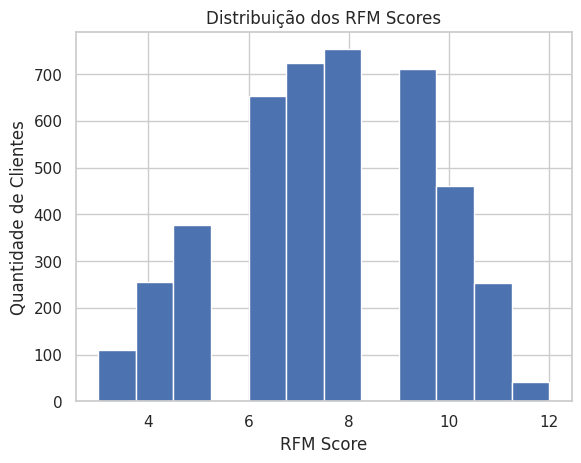

In [ ]:
# Distribuição dos RFM Scores
rfm_data['RFM_Score'].plot(kind='hist', bins=12)
plt.title('Distribuição dos RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Quantidade de Clientes')
plt.show()

3. Top 10 Clientes Mais Valiosos

Este código filtra os clientes com o menor RFM Score, que são considerados os mais valiosos, e mostra os 10 primeiros. Empresas podem usar essa informação para direcionar ofertas exclusivas, programas de fidelidade, ou serviços premium.

In [ ]:
# Identificando os top 10 clientes mais valiosos
top_10_customers = rfm_data[rfm_data['RFM_Score'] == rfm_data['RFM_Score'].min()].head(10)

In [ ]:
top_10_customers = rfm_data[rfm_data['RFM_Score'] == rfm_data['RFM_Score'].min()].head(10)

In [ ]:
# Encontrando os top 10 clientes mais valiosos com base no RFM Score
top_10_customers = rfm_data[rfm_data['RFM_Score'] == rfm_data['RFM_Score'].min()].head(10)

# Exibindo o resultado como uma tabela
top_10_customers

,R,F,M,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12388,15,100,27.806600,1,1,1,1.01.01.0,3
12433,0,420,31.847310,1,1,1,1.01.01.0,3
12437,1,199,24.881457,1,1,1,1.01.01.0,3
12451,10,354,25.524068,1,1,1,1.01.01.0,3
12471,1,459,43.112527,1,1,1,1.01.01.0,3
12476,15,233,29.255021,1,1,1,1.01.01.0,3
12524,8,144,31.150833,1,1,1,1.01.01.0,3
12583,2,247,29.479271,1,1,1,1.01.01.0,3
12621,1,467,29.314069,1,1,1,1.01.01.0,3


4. Relacionamento entre Recência, Frequência e Ticket Médio

Estes gráficos de dispersão nos ajudam a entender como as diferentes métricas RFM estão relacionadas entre si. Por exemplo, um alto valor de Frequência combinado com uma Recência baixa (recente) pode indicar um cliente muito engajado.

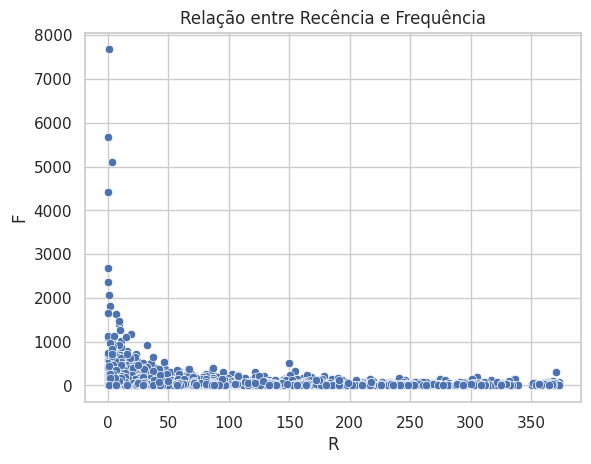

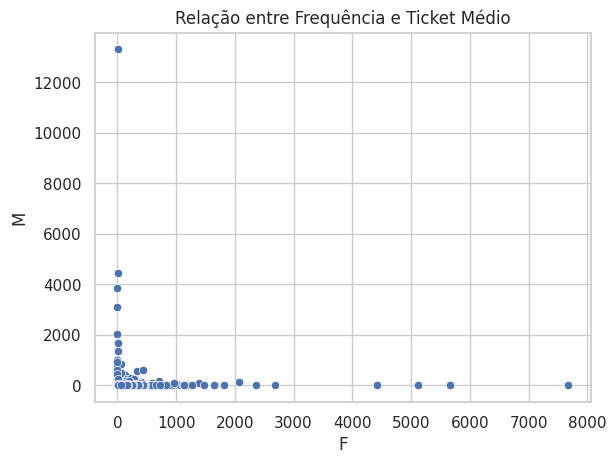

In [ ]:
# Plotando a relação entre Recência e Frequência
sns.scatterplot(x='R', y='F', data=rfm_data)
plt.title('Relação entre Recência e Frequência')
plt.show()

# Plotando a relação entre Frequência e Ticket Médio
sns.scatterplot(x='F', y='M', data=rfm_data)
plt.title('Relação entre Frequência e Ticket Médio')
plt.show()

5. Análise de Coorte de RFM

Analisar os clientes em coortes com base na sua pontuação RFM pode nos ajudar a entender o comportamento do cliente ao longo do tempo.

Um heatmap das coortes RFM nos permite visualizar a densidade de clientes em diferentes segmentos de RFM Score. Isso pode ajudar a identificar grupos de clientes que requerem atenção especial ou têm potencial para maior engajamento.


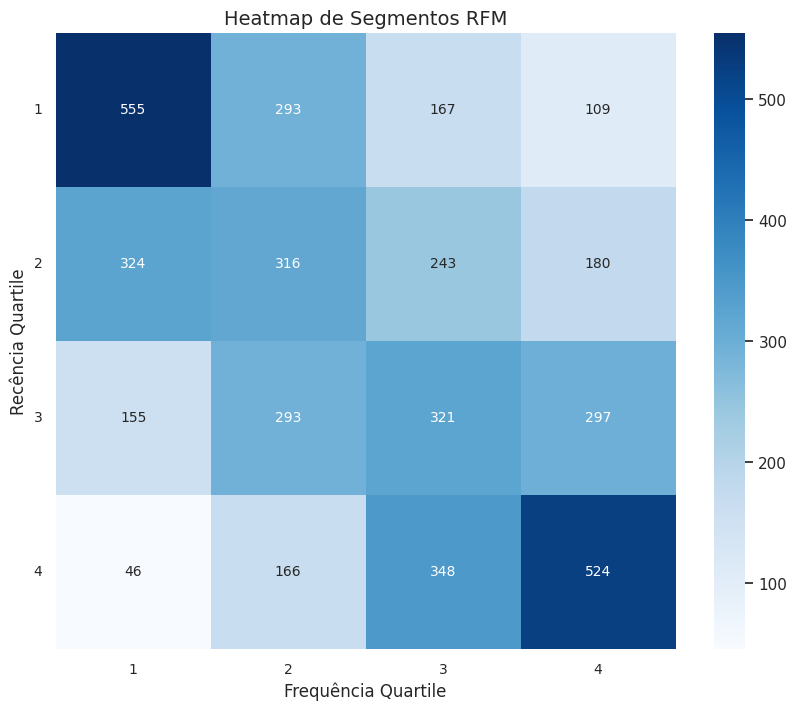

In [ ]:
# Novo DataFrame que conta quantos clientes caem em cada combinação de R e F quartile
rf_matrix = rfm_data.groupby(['R_quartile', 'F_quartile']).size().unstack()

# Heatmap usando esse novo DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(rf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 10})

# Adicione títulos e rótulos
plt.title('Heatmap de Segmentos RFM', fontsize=14)
plt.xlabel('Frequência Quartile', fontsize=12)
plt.ylabel('Recência Quartile', fontsize=12)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=0, fontsize=10)

plt.show()

# Insights Estratégicos

1. S**egmentação de Clientes**:

A segmentação RFM revelou grupos distintos de clientes, permitindo uma abordagem de marketing mais focada e personalizada. Por exemplo, clientes com alta recência e frequência, mas baixo ticket médio podem ser incentivados a fazer compras de maior valor através de promoções direcionadas ou programas de fidelidade.

2. **Clientes de Alto Valor**:

Identificamos um conjunto de clientes de alto valor que são cruciais para a receita da empresa. Estes clientes têm a maior combinação de recência, frequência e ticket médio. Manter um relacionamento próximo e satisfatório com esses clientes deve ser uma prioridade estratégica.

3. **Oportunidades de Reengajamento**:

A análise destacou segmentos de clientes com alta frequência de compras, mas baixa recência. Este é um grupo alvo para reengajamento, pois eles já demonstraram lealdade à marca no passado. Campanhas de reengajamento e ofertas especiais podem ser eficazes aqui.

4. **Desenvolvimento de Produtos e Ofertas**:

Os dados sobre os produtos mais vendidos oferecem insights para o desenvolvimento de produtos e ofertas. Itens que lideram em quantidade vendida podem ser chave para pacotes promocionais ou ofertas cruzadas com produtos menos vendidos para impulsionar suas vendas.

5. **Análise Temporal de Vendas**:

A análise das tendências de vendas ao longo do tempo destacou padrões sazonais, que podem informar o planejamento de estoque, marketing e promoções. Entender quando os clientes estão mais propensos a comprar pode ajudar na preparação para períodos de alta demanda e na maximização de receitas.

6. **Estratégias de Retenção**:

A distribuição dos scores RFM ilustrou a existência de um grupo significativo de clientes com pontuações médias a altas, sugerindo uma oportunidade de melhoria na retenção. Investir em estratégias de retenção e melhoria da experiência do cliente pode aumentar a frequência e o ticket médio desses clientes.

7. **Custo de Aquisição vs. Valor Vitalício**:

Ao combinar as métricas RFM com o custo de aquisição de clientes e o valor vitalício (LTV), a empresa pode identificar quais segmentos de clientes são os mais rentáveis e ajustar suas estratégias de marketing e aquisição para focar nesses grupos.

8. **Eficiência de Marketing**:

A análise mostrou que não todos os clientes são igualmente valiosos. Concentrar esforços de marketing nos segmentos de clientes mais propensos a responder (baseado em RFM) pode aumentar o ROI de campanhas de marketing.

9. **Personalização**:

Os insights obtidos a partir dos dados RFM reforçam a importância da personalização. Campanhas e comunicações personalizadas com base no comportamento de compra anterior dos clientes podem levar a uma maior satisfação e a um aumento nas vendas.

10. **Feedback do Produto**:

A análise dos produtos mais vendidos pode também fornecer feedback para o time de desenvolvimento de produto sobre o que está funcionando bem e o que pode ser melhorado ou expandindo na linha de produtos atual.